# This notebook demonstrates the base usage of the package

- Estimating travel times
- Plotting a single path



In [1]:
import driftmlp
import numpy as np
import matplotlib.pyplot as plt
#Note that this reads in a pre-made network. 
# This does not require one to download 
T_mat = driftmlp.read_default_network()
T_mat

### Using the module shortest_path

First we'll do a single shortest path. 
Just pick two points and store them in a length 2 list. Each being a longitude, latitude pair in that order.

In [2]:
from_loc = [-90.90, 23.88]
to_loc =[-9.88, 35.80] 
SP = driftmlp.shortest_path.SingleSP(T_mat, from_loc, to_loc)
display(SP)

From: [-90.9, 23.88], To: [-9.88, 35.8]
Travel time for the forward journey(blue)
2.62 Years
Travel time for the return journey(red)
2.43 Years

There are two plotting backends avalible, one with folium for interactive style plots. Note folium only works with h3 grid systems

In [3]:
SP.plot_folium()

 The other using cartopy, which works on top of matplotlib

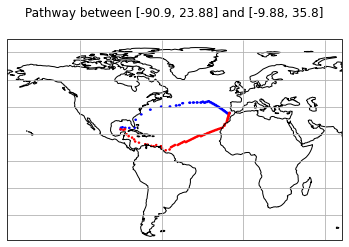

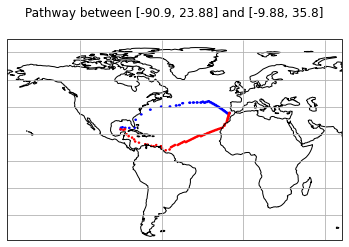

In [4]:
fig, ax = SP.plot_cartopy()
ax.gridlines()
ax.set_title(f"Pathway between {from_loc} and {to_loc}")
fig

### More detailed use
SingleSP is a class which contains two shortest paths, one for the to direction, one for the return.

In [5]:
# The default h3 system
discretizer = driftmlp.DefaultSystem

# Inside SingleSP it does all the below
from_index = discretizer(*from_loc)
to_index = discretizer(*to_loc)
path = driftmlp.shortest_path.network_path(T_mat, from_index, to_index)

# path is equivalent to what is stored in SP.sp
path.h3id==SP.sp.h3id

True

To analyse the travel time to figure out why travel times are shorter/longer looking at travel time plots is usually a good idea.

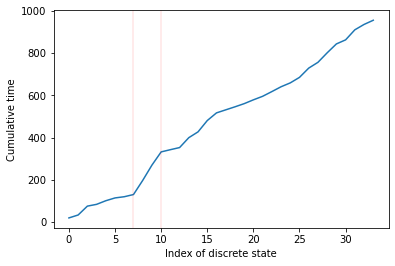

In [6]:
fig, ax = plt.subplots()
aggregated_time = np.cumsum(path.travel_time_list)
ax.plot(aggregated_time)
ax.set_ylabel("Cumulative time")
ax.set_xlabel("Index of discrete state")

ax.axvline(x=7, color='r', alpha=0.1)
ax.axvline(x=10, color='r', alpha=0.1)

Now we see there is a relatively steep slope between the 7th and 10th index. 

We'll investigate further while giving a demonstration of how plotting works in the package.


CPU times: user 19.4 s, sys: 667 ms, total: 20 s
Wall time: 20.2 s


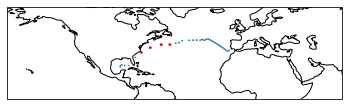

In [7]:
from driftmlp.plotting import h3_cartopy
from driftmlp.plotting import h3_plotly
#Makes the dataframe containing all the geometric information
%time gpd_df  = driftmlp.plotting.make_gpd.full_multipolygon_df()
ax = h3_cartopy.plot_hex(h3_gpd= gpd_df, h3_inds=path.h3id)
#Don't reduce the map extent based on the subset
ax = h3_cartopy.plot_hex(h3_gpd= gpd_df, h3_inds=path.h3id[7:11], ax=ax, color='red', set_extent=False)

ax.coastlines()

In [8]:
h3_plotly.visualize_hexagons(path.h3id[7:11])

We can see the travel time slope in the plot actually corresponds to a large physical distance even though it only covers 4 discrete states.

### Pairwise distances

Finally one of the more interesting usages of the package is to look at pairwise distances. We'll select a couple of random locations then make some pairwise plots.

In [9]:
locs = {
    "Gulf of Mexico": from_loc,
    "Strait of Gibraltar": to_loc,
    "North Atlantic" : [-41, 34],
    "South Atlantic" : [-14, -27], 
    "North Pacific" : [-170, 30]
}
N_locs = len(locs)

One way to do this would be to just the SingleSP method to fill in a pairwise matrix.

In [10]:
%time
dist_matrix = np.zeros((N_locs, N_locs))
paths = {}
locs_list = list(locs.values())
locs_name = list(locs.keys())
for i in range(N_locs):
    from_point = locs_list[i]
    for j in range(i+1, N_locs):
        to_point = locs_list[j]
        path = driftmlp.shortest_path.SingleSP(T_mat, from_point, to_point)
        dist_matrix[i,j] = path.sp.travel_time
        dist_matrix[j,i] = path.sp_rev.travel_time
        # Save path to access later
        paths[f'{locs_name[i]}_{locs_name[i]}'] = path

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


Now we can plot a heatmap. This example is adapted from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

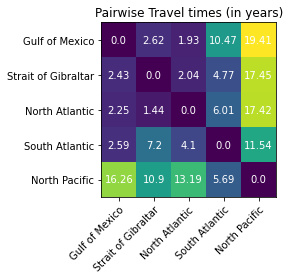

In [11]:
fig, ax = plt.subplots()
ax.set_xticks(np.arange(N_locs))
ax.set_yticks(np.arange(N_locs))
# ... and label them with the respective list entries
ax.set_xticklabels(locs_name)
ax.set_yticklabels(locs_name)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(N_locs):
    for j in range(N_locs):
        text = ax.text(j, i, np.round(dist_matrix[i, j]/365,2) ,
                       ha="center", va="center", color="w")

ax.set_title("Pairwise Travel times (in years)")

ax.imshow(dist_matrix)
fig.tight_layout()
plt.show()

### Efficiency
Even though time is not an issue for this example, the package also has a quicker way to extract pathways. 

The time difference does not matter for a small example such as the one here but when looking at many more locations (N_locs=100) this time difference will be much larger. The efficiency gain comes as the shortest path algorithm called can run one to N_locs pathway calculations faster than doing N_loc calls of a one to one algorithm.

In [12]:
%time
## Get the indices onces,
h3_ids = driftmlp.DefaultSystem.return_inds(locs_list)
display(h3_ids)
pairwise_paths = driftmlp.shortest_path.AllPairwisePaths(T_mat, h3_ids)
dist_matrix_2 = np.array([[path.travel_time for path in list_of_paths] for list_of_paths in pairwise_paths])
dist_matrix_2==dist_matrix

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


[591191047019692031,
 590985713223204863,
 591014025647620095,
 593368354920595455,
 591221352308932607]

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

### What next

This notebook covers the base use of the package. The main extra extension is the uncertainty part. 

- These pathways are based off limited data. The bootstrap extension helps asses how much of this uncertainty is due to a lack of data.
- The pathways rely on a discrete grid system assumption. The rotation methodology gives a measure of uncertainty due to the discretization step.